In [22]:
import pandas as pd
import numpy as np
import glob
import datetime
import heapq as heap
from os.path import basename
# Imports to use TensorFlow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# Imports to graph t-SNE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# Imports for xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score
# Imports for Elapsed Time Prediction
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

# Pandas options
pd.options.display.max_columns = 1200
pd.options.display.max_rows = 1200

# Section 1: Combine Tracklib and Cobalt DJC logs

If you have already run Section 1, or have an existing copy of the combined `.csv`, skip to **Section 2**.

In [2]:
# Read in TrackLib dataset
libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')

In [3]:
libdf.describe()

,COBALT_JOBID
count,5.945080e+06
mean,1.124442e+06
std,4.114922e+05
min,4.144250e+05
25%,7.845130e+05
50%,1.022880e+06
75%,1.448592e+06
max,2.007052e+06


In [7]:
len(libdf.COBALT_JOBID.unique())

158294

In [50]:
# Read in Cobalt logs dataset
djc_df = pd.read_csv('../data/tracklib/mira_djc_complete/dim_job_composite.csv')

In [86]:
# Take cobalt logs and add a column for each short library name
df = djc_df.assign(**dict.fromkeys(libdf.LIB_SHORT_NAME.unique(), 0))

,COBALT_JOBID,QUEUED_DATE_ID,START_DATE_ID,END_DATE_ID,WALLTIME_SECONDS,RUNTIME_SECONDS,NODES_USED,NODES_REQUESTED,CORES_USED,CORES_REQUESTED,...,gsl,netcdf,valgrind,essl_fftw,silo,bgclang,essl,darshan,scorep,metis
count,2.763140e+05,2.763140e+05,2.763140e+05,2.763140e+05,276314.000000,276314.000000,276314.000000,276314.000000,276314.000000,276314.000000,...,276314.0,276314.0,276314.0,276314.0,276314.0,276314.0,276314.0,276314.0,276314.0,276314.0
mean,1.046564e+06,2.016660e+07,2.016663e+07,2.016663e+07,11508.103838,7349.374773,2053.188300,2013.286880,32851.012804,32212.590082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5.344312e+05,1.365261e+04,1.364564e+04,1.364466e+04,14334.547058,11750.518818,4310.332276,4307.036097,68965.316411,68912.577552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,3.522200e+05,2.014103e+07,2.014123e+07,2.015010e+07,180.000000,15.000000,0.000000,1.000000,0.000000,16.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,6.183280e+05,2.015093e+07,2.015093e+07,2.015093e+07,2400.000000,425.000000,512.000000,512.000000,8192.000000,8192.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,9.727955e+05,2.016120e+07,2.016121e+07,2.016121e+07,6000.000000,2666.000000,512.000000,512.000000,8192.000000,8192.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.538465e+06,2.018051e+07,2.018051e+07,2.018051e+07,18000.000000,9563.000000,2048.000000,2048.000000,32768.000000,32768.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.999000e+07,2.019073e+07,2.019073e+07,2.019073e+07,217200.000000,217243.000000,49152.000000,49152.000000,786432.000000,786432.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# One-hot encode library names into djc_df
# THIS IS VERY INEFFICIENT, DON'T RUN UNLESS YOU NEED TO.
# TAKES ~1 hour to run on flick 🙃
for lib in libdf.LIB_SHORT_NAME.unique():
    temp_df = libdf[libdf['LIB_SHORT_NAME'] == lib]
    temp_df.set_index('COBALT_JOBID', inplace=True)
    def helper(row):
        if row['COBALT_JOBID'] in temp_df.index:
            row[lib] = 1
            return row
        else:
            return row
    df = df.apply(helper, axis=1)

In [103]:
# Write it out to .csv so we don't have to run this terribly inefficient
# code every time
df.to_csv('../data/tracklib/tracklib_djc.csv')

# Section 2: Clean and Filter Combined Dataset

If you already have a filtered `.csv` you want to use, skip to **Section 3**.

* Parameters:
    * n
        * Number of top corehours consumers to include
        * Possible values: >=0
        * Set to 0 to include all of them

In [34]:
# Parameters
n = -1

In [35]:
# Read in the various dataframes if you need to
df = pd.read_csv('../data/tracklib/tracklib_djc.csv', header=0, low_memory=False)
libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')

In [36]:
df.isnull().sum().sum()

1014

In [37]:
# Drop Nans and w.ipynb_checkpoints/ird column 
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

In [38]:
# Filter combined dataset based on date overlap
df = df[df.START_TIMESTAMP > libdf.START_TIMESTAMP.min()]

In [39]:
# Add a column for an executable name/project name feature
def exec_maker(row):
    return str('%s.%s' % (row['PROJECT_NAME'], basename(row['COMMAND']))) 

df['EXEC'] = df.apply(exec_maker, axis=1)

In [40]:
# Filter by top n core hour consumers
# df_filtered = pd.DataFrame()
# if n > 0:
#     names = df.EXEC.unique()
#     core_hours_dict = {}
#     for name in names:
#         core_hours_dict.update({name : df.USED_CORE_HOURS.sum()})
#     top_names = heap.nlargest(n, core_hours_dict, key=core_hours_dict.get)
#     for name in top_names:
#         df_filtered = df_filtered.append(df[df['EXEC'] == name])
# else:
#     df_filtered = df.copy()

# n_top_execs = df.EXEC.value_counts().head(n - 1)
# df_filtered = df[df.EXEC.isin(n_top_execs.keys())]

if n > 0:
    n_top_execs = df.EXEC.value_counts().head(n)
    not_n_top_execs = [executable for executable in df.EXEC.unique() if executable not in n_top_execs]
    df_filtered = df.copy()
    df_filtered.loc[df_filtered.EXEC.isin(not_n_top_execs), 'EXEC'] = 'other'
else:
    df_filtered = df.copy()

In [41]:
# Save to a '.csv'
if n > 0:
    df_filtered.to_csv('../data/tracklib/tracklib_djc_filtered_' + str(n) + '.csv')
else:
    df_filtered.to_csv('../data/tracklib/tracklib_djc_filtered.csv')

# Section 3: TensorFlow Model

* Parameters:
    * m
        * number of top corehours consumers to include.
        * Possible values: >=0
        * Set to 0 to include all of them. 
        * Set to n to use the value from **Section 2**.
    * train_size
        * how much of the full dataset to use for training
        * Possible values: 0 to 1

In [42]:
# Parameters
m = -1
train_size = .8

In [43]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [44]:
# df_filtered = df_filtered.sample(frac=1)

In [183]:
# Select features and targets to use for model
features = df_filtered.select_dtypes(include=[np.number]).copy()
features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
features = features.drop([column for column in features.columns if 'ID' in column], axis=1)
features = features.drop([column for column in features.columns if 'unnamed' in column.lower()], axis=1)

targets = pd.DataFrame()
targets['number'] = pd.factorize(df_filtered['EXEC'])[0]

In [184]:
# # EXPERIMENT: Drop everthing except libraries
# features = features.drop([column for column in features.columns if 'NUM' in column], axis=1)
# features = features.drop([column for column in features.columns if 'SECONDS' in column], axis=1)
# features = features.drop([column for column in features.columns if 'USED' in column], axis=1)
# features = features.drop([column for column in features.columns if 'CORE' in column], axis=1)
# features = features.drop([column for column in features.columns if 'NODE' in column], axis=1)
# features = features.drop([column for column in features.columns if 'IS' in column], axis=1)
# features = features.drop([column for column in features.columns if 'EXIT' in column], axis=1)
# features = features.drop([column for column in features.columns if 'FACTOR' in column], axis=1)

# for columns in features.columns:
#     print(columns)

In [185]:
# # EXPERIMENT: Test without libraries
# features = features.drop([column for column in features.columns if column.islower()], axis=1)

In [186]:
# EXPERIMENT: Drop features we don't have access to before runtime
features = features.drop([column for column in features.columns if 'RUNTIME_SECONDS' in column], axis=1)
features = features.drop([column for column in features.columns if 'NODES_USED' in column], axis=1)
features = features.drop([column for column in features.columns if 'CORES_USED' in column], axis=1)
features = features.drop([column for column in features.columns if 'EXIT_STATUS' in column], axis=1)
features = features.drop([column for column in features.columns if 'USED_CORE_HOURS' in column], axis=1)
features = features.drop([column for column in features.columns if 'COBALT_NUM_TASKS' in column], axis=1)
features = features.drop([column for column in features.columns if 'ELIGIBLE' in column], axis=1)
features = features.drop([column for column in features.columns if 'QUEUED' in column], axis=1)
features = features.drop([column for column in features.columns if 'USAGE' in column], axis=1)
features = features.drop([column for column in features.columns if 'EXIT_CODE' in column], axis=1)
features = features.drop([column for column in features.columns if 'NUM_TASK' in column], axis=1)
features = features.drop([column for column in features.columns if 'IS_' in column], axis=1)

features.columns

Index(['WALLTIME_SECONDS', 'NODES_REQUESTED', 'CORES_REQUESTED',
       'REQUESTED_CORE_HOURS', 'OVERBURN_CORE_HOURS', 'bgsys-gnu-linux',
       'bgsys-gnu-linux-4.7.2', 'autoperf', 'bgsys-comm', 'bgsys-hwi',
       'ibmcmp', 'bgsys-bgpm', 'bgsys-spi', 'qmcpack', 'bgsys-cnk', 'fftw',
       'zlib', 'hdf5', 'lapack', 'bgclang', 'essl', 'darshan'],
      dtype='object')

In [187]:
# Normalize features between 0 and 1 - plays nice with our neural network
# features = ((features - features.mean()) / (features.max() - features.min()))

In [188]:
# Separate our data into training and test sets
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [189]:
# Define our TensorFlow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu', input_shape=(len(features.columns.values),)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(targets.number.unique().size, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [190]:
# Compile our model
model.compile(optimizer=tf.train.AdagradOptimizer(0.05),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'],
            )

In [191]:
# Train model
model.fit(train_examples,
          train_targets,
          epochs=10,
         )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 47044 samples
Epoch 1/10
47044/47044 [==============================] - 3s 56us/sample - loss: 239.5653 - sparse_categorical_accuracy: 0.1297
Epoch 2/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.9880 - sparse_categorical_accuracy: 0.1455
Epoch 3/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.7578 - sparse_categorical_accuracy: 0.2025
Epoch 4/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.6550 - sparse_categorical_accuracy: 0.2187
Epoch 5/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.6119 - sparse_categorical_accuracy: 0.2265
Epoch 6/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.6083 - sparse_categorical_accuracy: 0.2309
Epoch 7/10
47044/47044 [==============================] - 2s 40us/sample - loss: 2.5885 - sparse_cate

In [192]:
# Calculate Test Accuracy to make sure we haven't overfit
test_acc = model.evaluate(test_examples, test_targets)
print('Test accuracy:', test_acc)

11760/11760 [==============================] - 0s 21us/sample - loss: 2.5017 - sparse_categorical_accuracy: 0.2456
Test accuracy: [2.5017234156731845, 0.24557823]


# Section 4: T-SNE Model

Use Zhengchung's t-sne plotting code to make a half-decent plot of a T-SNE representation.

In [372]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [373]:
features = df_filtered.select_dtypes(include=[np.number]).copy()
features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
features = features.drop([column for column in features.columns if 'ID' in column], axis=1)

In [374]:
# Train T-SNE
X_embedded = TSNE().fit_transform(features)
X_embedded.shape

(236167, 2)

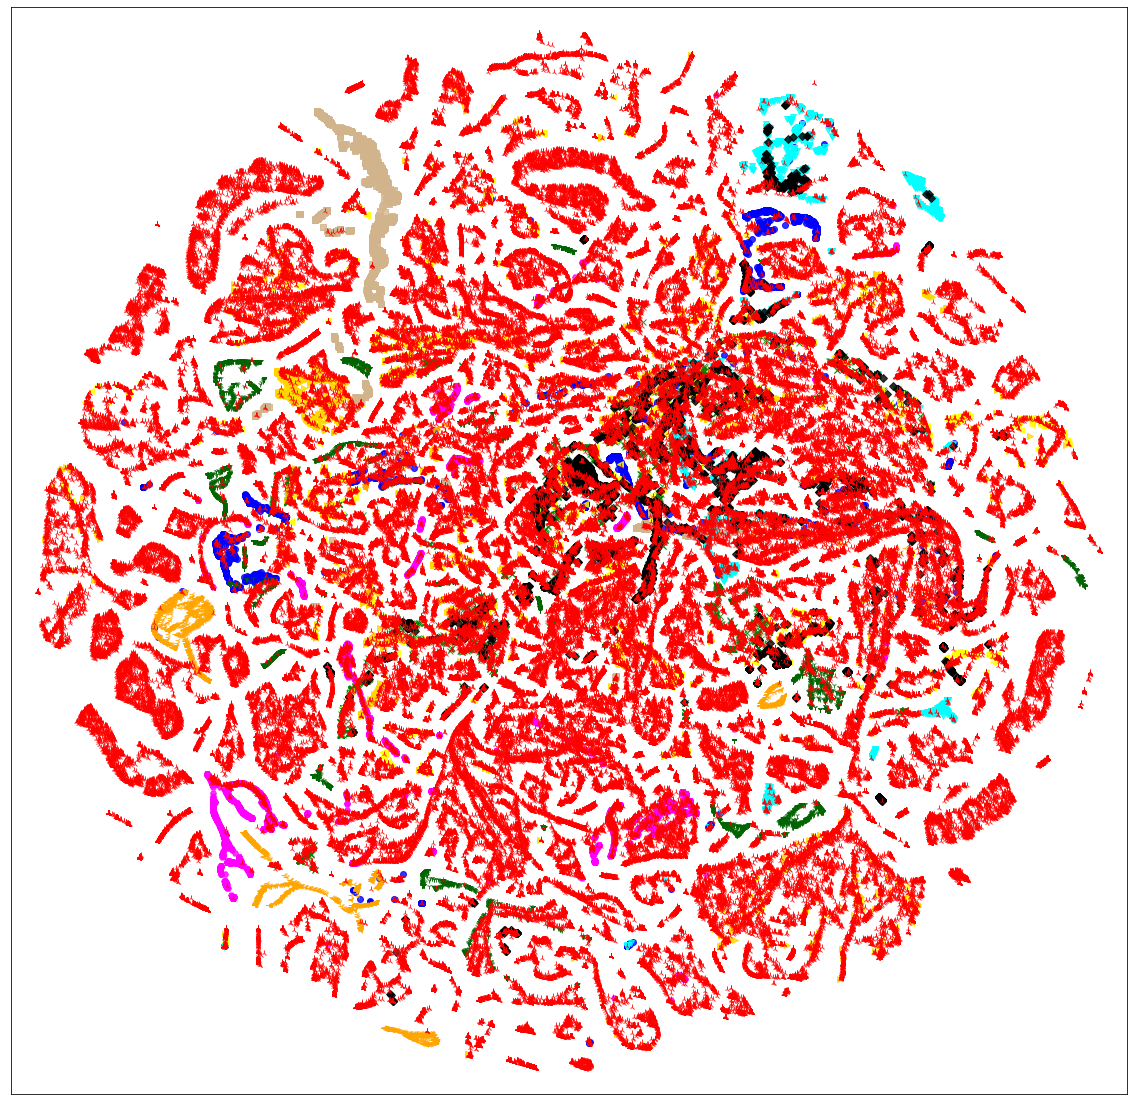

In [375]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=10):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx], alpha=.8, color=colors[_idx], markersize=6, label = _idn)
        _other_grp |= (exe_idn == _idn)
#         print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
#     plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=True, framealpha=0.5, fontsize=14)
    plt.show()
    plt.close()
t_sne_vis_by_group(X_embedded, df_filtered['EXEC'].values)

# XGBoost Model

In [376]:
# Parameters
m = 20
train_size = .8

In [490]:
# Read in the various dataframes if you need to
# df = pd.read_csv('../data/tracklib/tracklib_djc.csv')
# libdf = pd.read_csv('../data/tracklib/tracklib_mira_20200227.csv')
# djc_df = pd.read_csv('../data/mira_djc_complete/dim_job_composite.csv')
if m > 0:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered_' + str(m) + '.csv')
else:
    df_filtered = pd.read_csv('../data/tracklib/tracklib_djc_filtered.csv')

In [491]:
df_filtered = df_filtered[(df_filtered.START_TIMESTAMP >= '2016-01-01 00:00:00') & (df_filtered.START_TIMESTAMP < '2017-01-01 00:00:00')]

In [492]:
df_filtered = df_filtered[df_filtered.WALLTIME_SECONDS >= df_filtered.RUNTIME_SECONDS]

In [493]:
df_filtered = df_filtered[df_filtered['EXIT_STATUS'] == 0]

In [494]:
# df_filtered = df_filtered.sample(frac=1)

In [495]:
len(df_filtered.index)

39222

In [496]:
features = pd.DataFrame()
features['WALLTIME_SECONDS'] = df_filtered['WALLTIME_SECONDS']
for column in df_filtered.columns:
    if column.islower():
        features[column] = df_filtered[column]

cols = ['USERNAME', 'PROJECT_NAME', 'QUEUE_NAME', 'EXEC', 'NODES_REQUESTED', 'REQUESTED_CORE_HOURS']
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, categories='auto')
enc.fit(df_filtered[cols])
features = pd.concat([features.reset_index(drop=True), pd.DataFrame(enc.transform(df_filtered[cols]))], axis=1)
# features = pd.concat([features, pd.DataFrame(enc.transform(df_filtered[cols])).reindex(features.index)], axis=1)

targets = df_filtered.RUNTIME_SECONDS

In [497]:
# features[features.isnull().any(axis=1)]

In [498]:
len(features.index)

39222

In [499]:
# Select features and targets to use for model
# features = df_filtered.select_dtypes(include=[np.number]).copy()
# features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)
# features = features.drop([column for column in features.columns if 'ID' in column], axis=1)
# features = features.drop([column for column in features.columns if 'unnamed' in column.lower()], axis=1)

# targets = df_filtered.RUNTIME_SECONDS

In [500]:
# # EXPERIMENT: Test without libraries
# features = features.drop([column for column in features.columns if str(column).islower()], axis=1)

In [501]:
# enc = LabelBinarizer()
# enc.fit(df_filtered.EXEC.values.reshape(-1, 1))
# encoding = enc.transform(df_filtered.EXEC.values.reshape(-1,1))
# features = pd.concat([features, pd.DataFrame(encoding)], axis=1)

In [502]:
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [503]:
# xgb_model = xgb.XGBClassifier(objective="multi:softprob", max_depth=10)
# xgb_model.fit(train_examples, train_targets.values.ravel())

In [504]:
# accuracy_score(test_targets, xgb_model.predict(test_examples))

# Elapsed Time Prediction

In [505]:
# # param_grid = {'n_estimators'    :[100, 200, 300, 400, 500, 600, 1000][-3:],\
# #          'max_depth'       :[5, 10, 20, 30, 40, 50][-3:],} 
# param_grid = {
#     'max_depth': [10, 20],
#     'n_estimators': [10, 20],
# #     'max_depth': [10, 15, 20, 30],
# #     'n_estimators': [10, 15, 25, 50],
# #     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
# #     'reg_alpha': [1.2, 1.3, 1.4, 1.5],
# #     'reg_lambda': [1, 1.1, 1.2, 1.3, 1.5],
# #     'subsample': [.5, .6, .7, .8, .9],
# }

# grid = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = param_grid, n_jobs=-1, cv=3, verbose=2)

# grid.fit(train_examples, train_targets)

In [506]:
# grid.best_estimator_

In [507]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_examples, train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [508]:
# pred    = grid.best_estimator_.predict(test_examples)
pred = xgb_model.predict(test_examples)
error   = pred - test_targets
abs_err = np.abs(error)
rel_err = 100. * abs_err / test_targets
print(np.percentile(rel_err, 25), np.percentile(rel_err, 50), np.percentile(rel_err, 75), np.percentile(rel_err, 95))
print(np.percentile(abs_err, 25), np.percentile(abs_err, 50), np.percentile(abs_err, 75), np.percentile(abs_err, 95))

11.424333407436636 14.397751517255367 39.77977984139494 990.5536625309901
241.386962890625 313.6011962890625 1327.8443603515625 7385.93378906249


(array([7.686e+03, 8.800e+01, 3.800e+01, 1.300e+01, 3.000e+00, 7.000e+00,
        6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([6.88697045e-03, 4.73753117e+03, 9.47505546e+03, 1.42125797e+04,
        1.89501040e+04, 2.36876283e+04, 2.84251526e+04, 3.31626769e+04,
        3.79002012e+04, 4.26377255e+04, 4.73752497e+04]),
 <a list of 10 Patch objects>)

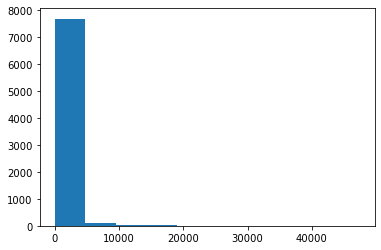

In [455]:
# plt.hist(rel_err, bins=30)
plt.hist(rel_err)

In [456]:
# top_feat_idx = np.argsort(grid.best_estimator_.feature_importances_)[-15:]
top_feat_idx = np.argsort(xgb_model.feature_importances_)[-15:]
features.columns[top_feat_idx]

Index([               516,                448,                266,
                      193,                119,                299,
                      490, 'WALLTIME_SECONDS',                453,
                      494,                377,                491,
                      169,                  4,                679],
      dtype='object')

In [457]:
# for i in range(len(pred)):
#     pred[i] = min(pred[i], test_examples.WALLTIME_SECONDS.to_list()[i])

In [486]:
nodes = df_filtered.NODES_REQUESTED.tail(int(len(df_filtered.index) * (1-train_size)))
cushion = 720*60

In [487]:
# Distribution of difference between runtime and new walltime w/ cushion
((pred + cushion) - test_targets).describe()

count      7844.000000
mean      43142.924119
std        4876.625812
min       16419.687500
25%       42387.921875
50%       43074.416016
75%       43364.207031
max      112460.890625
Name: RUNTIME_SECONDS, dtype: float64

In [488]:
# Number of jobs cutoff w/ new walltimes
array = ((pred + cushion) - test_targets)
print(len([item for item in array if item < 0]))
# [item for item in array if item <= 0]

0


In [489]:
# Jobs which benefited
saved_array = ((test_examples.WALLTIME_SECONDS - (pred + cushion)))
print(len([item for item in saved_array if item >= 0]))

3


In [297]:
indices = [i for i in range(len(array.values)) if array.values[i] <= 0]

In [298]:
examples = test_examples.iloc[indices]
examples = examples.drop(examples.columns[(examples == 0).all()], 1)

In [299]:
walltimes = test_targets.iloc[indices]

In [300]:
# examples

In [301]:
# df_filtered.loc[4955]

In [302]:
# Percentage of jobs cutoff
len([item for item in ((pred + cushion) - test_targets) if item <= 0])/len(test_targets) * 100

0.039619651347068144

In [303]:
# Walltime hours cutoff
sum([item for item in (((pred + cushion) - test_targets)) if item <= 0]) / 3600

-9.255530598958334

In [304]:
# Nodehours cutoff
sum([item for item in (((pred + cushion) - test_targets) * nodes) if item <= 0]) / 3600

-115956.80888888889

In [305]:
# Nodehours saved
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).sum() / 3600

0.0

In [306]:
# Total nodehours
(test_examples.WALLTIME_SECONDS * nodes).sum() / 3600

0.0

In [307]:
# Saved nodehours percentage
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).sum() / (test_examples.WALLTIME_SECONDS * nodes).sum()

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


nan

In [308]:
# Total walltime cutoff
sum([item for item in (((pred + cushion) - test_targets)) if item <= 0]) / 3600

-9.255530598958334

In [309]:
# Total walltime saved
((test_examples.WALLTIME_SECONDS - (pred + cushion))).sum() / 3600

-128778.61947699652

In [310]:
# Total walltime hours scheduled
(test_examples.WALLTIME_SECONDS).sum() / 3600

24077.1

In [101]:
# Saved walltime percentage
((test_examples.WALLTIME_SECONDS - (pred + cushion))).sum() / (test_examples.WALLTIME_SECONDS * nodes).sum()

/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


inf

In [102]:
# Distribution of difference between old walltime and new walltime w/ cushion
((test_examples.WALLTIME_SECONDS - (pred + cushion))).describe()

count     9140.000000
mean      4402.568139
std       7925.174287
min     -10565.515625
25%       -346.282959
50%       1958.551270
75%       7198.405273
max      76221.748047
Name: WALLTIME_SECONDS, dtype: float64

In [103]:
# Distribution of difference between old walltime and new walltime w/ cushion in nodehours
((test_examples.WALLTIME_SECONDS - (pred + cushion)) * nodes).describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [582]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

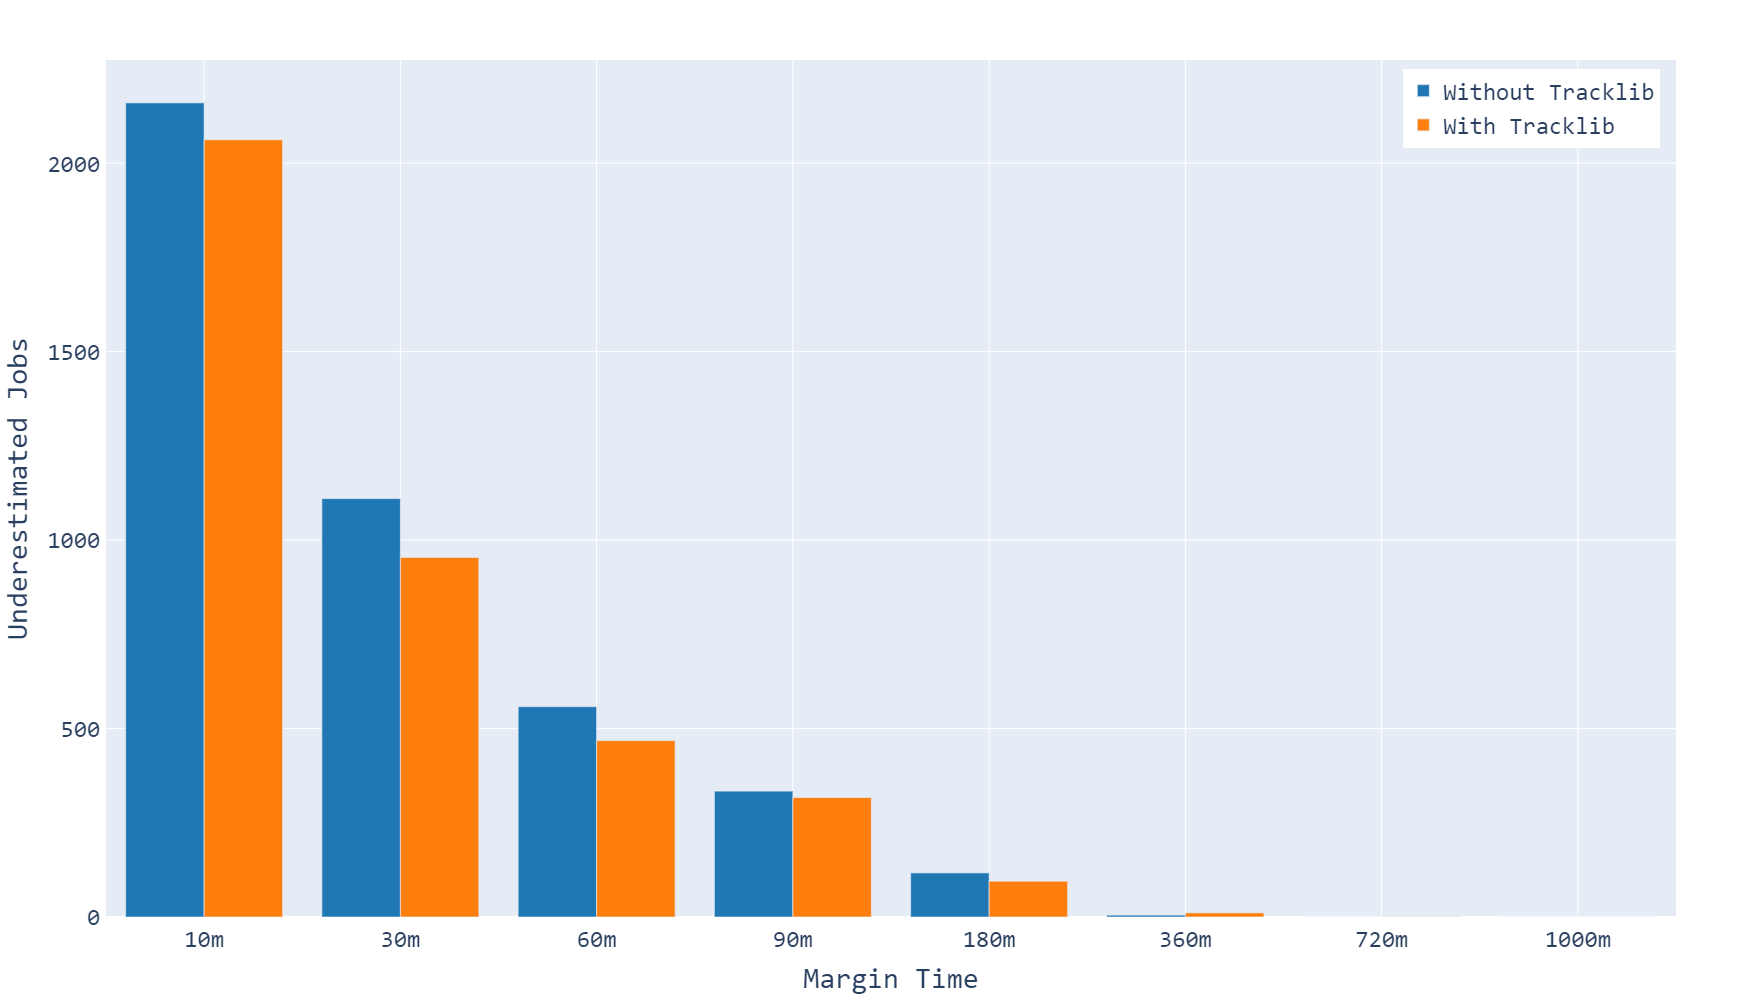

In [632]:
x = ["10m", "30m", "60m", "90m", "180m", "360m", "720m", "1000m"]
no_tracklib = [2160, 1110, 558, 334, 117, 5, 0, 0]
tracklib = [2062, 954, 468, 317, 95, 11, 1, 0]
fig = px.bar(pd.DataFrame({"Margin Time": x, "With Tracklib": tracklib, "Without Tracklib": no_tracklib}), x="Margin Time", y=["Without Tracklib", "With Tracklib"], barmode='group', height=1000, width=1000, color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    legend_title=None,
    font_family="Consolas",
    font_size=24,
    yaxis_title="Underestimated Jobs",
)
fig.show()

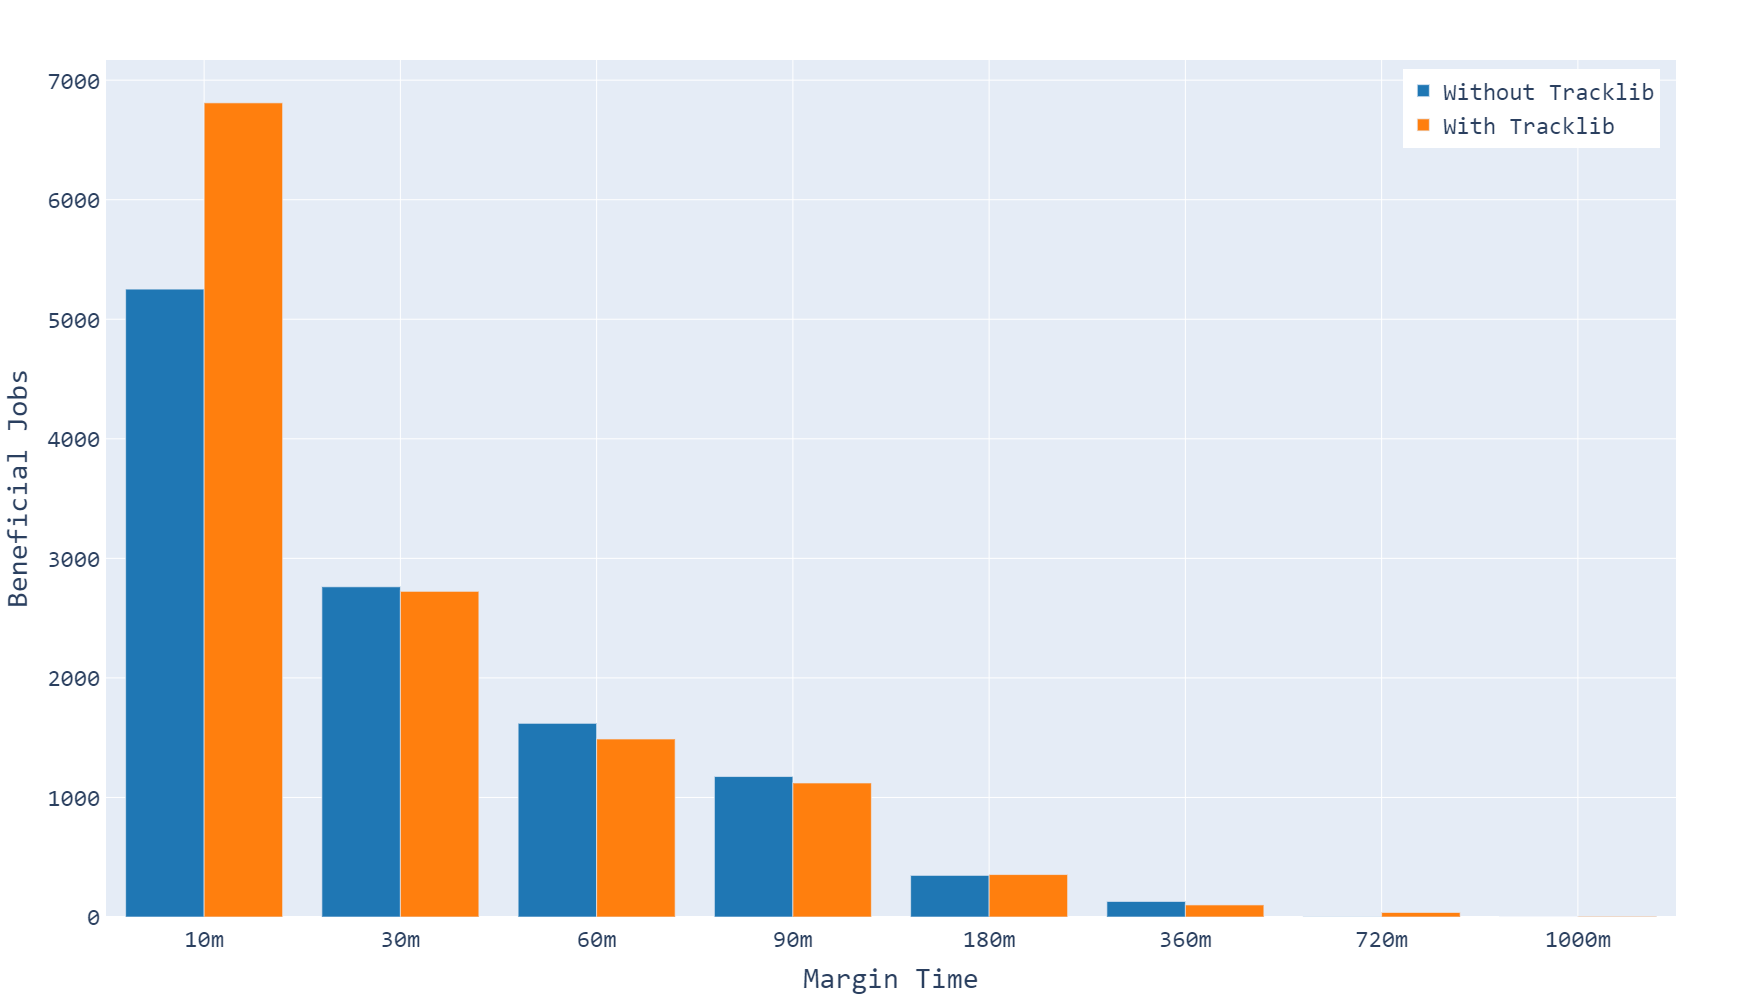

In [631]:
no_tracklib = [5252, 2762, 1620, 1175, 348, 130, 3, 0]
tracklib = [6810, 2724, 1489, 1121, 355, 101, 38, 6]
fig = px.bar(pd.DataFrame({"Margin Time": x, "With Tracklib": tracklib, "Without Tracklib": no_tracklib}), x="Margin Time", y=["Without Tracklib", "With Tracklib"], barmode='group', height=1000, width=1000, color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    legend_title=None,
    font_family="Consolas",
    font_size=24,
    yaxis_title="Beneficial Jobs"
)
fig.show()